In [197]:
!pip install pandas matplotlib numpy scikit-learn seaborn xgboost -q

In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

Erste Zeilen der Daten:
   ID       y  X0 X1  X2 X3 X4 X5 X6 X8  ...  X375  X376  X377  X378  X379  \
0   0  130.81   k  v  at  a  d  u  j  o  ...     0     0     1     0     0   
1   6   88.53   k  t  av  e  d  y  l  o  ...     1     0     0     0     0   
2   7   76.26  az  w   n  c  d  x  j  x  ...     0     0     0     0     0   
3   9   80.62  az  t   n  f  d  x  l  e  ...     0     0     0     0     0   
4  13   78.02  az  v   n  f  d  h  d  n  ...     0     0     0     0     0   

   X380  X382  X383  X384  X385  
0     0     0     0     0     0  
1     0     0     0     0     0  
2     0     1     0     0     0  
3     0     0     0     0     0  
4     0     0     0     0     0  

[5 rows x 378 columns]

Dateninformationen:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 378 entries, ID to X385
dtypes: float64(1), int64(369), object(8)
memory usage: 12.1+ MB
None

Statistische Zusammenfassung der numerischen Daten:
                ID          

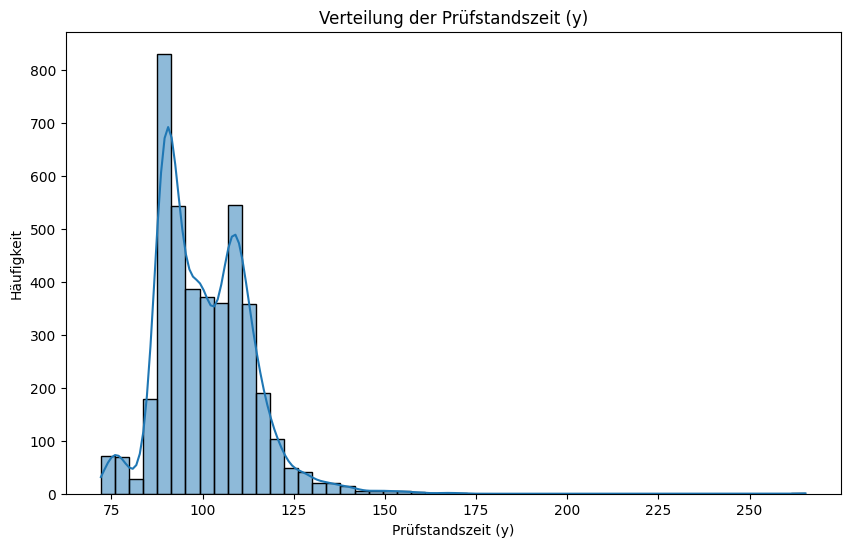

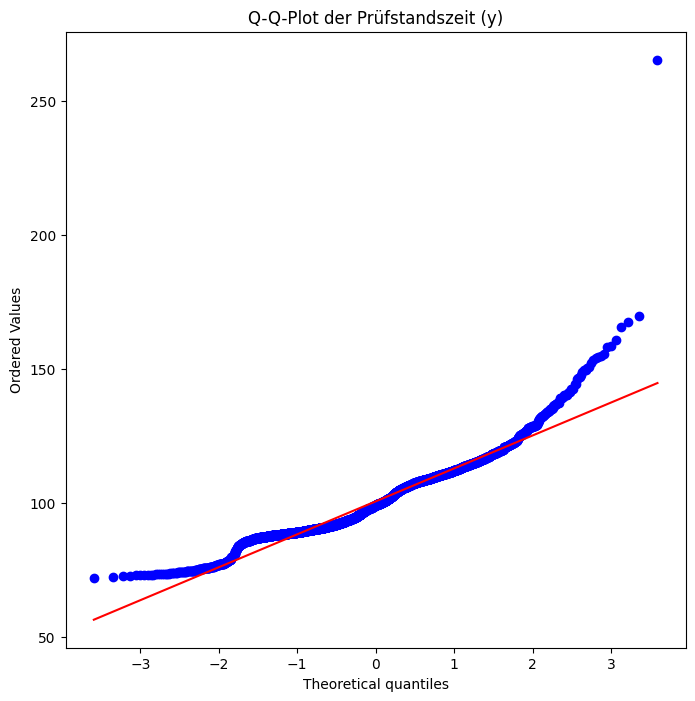

In [199]:
def load_and_explore_data(file_path):
    """
    Lädt den Datensatz, zeigt grundlegende Informationen und gibt erste Einblicke in die Verteilung der Zielvariable.
    """
    # Daten laden
    df = pd.read_csv(file_path)

    # Erste Informationen anzeigen
    print("Erste Zeilen der Daten:")
    print(df.head())

    print("\nDateninformationen:")
    print(df.info())

    print("\nStatistische Zusammenfassung der numerischen Daten:")
    print(df.describe())

    # Verteilung der Zielvariable visualisieren
    plt.figure(figsize=(10, 6))
    sns.histplot(df["y"], kde=True, bins=50)
    plt.title("Verteilung der Prüfstandszeit (y)")
    plt.xlabel("Prüfstandszeit (y)")
    plt.ylabel("Häufigkeit")
    plt.show()

    import scipy.stats as stats

    # Visaualisierung der Quantil-Quantil-Plot
    # Dieser Plot zeigt, ob die Verteilung der Zielvariablen normalverteilt ist
    # Wenn die Punkte auf der Geraden liegen, ist die Verteilung normalverteilt
    plt.figure(figsize=(8, 8))
    stats.probplot(df["y"], dist="norm", plot=plt)
    plt.title("Q-Q-Plot der Prüfstandszeit (y)")
    plt.show

    return df


df = load_and_explore_data("data/train.csv")

Die Verteilung der Zielvariable zeigt, dass sie grob an einer Normalverteilung orientiert ist.

Strategie zur Problemlösung:

1. Datensatz untersuchen (sehr viele Features, ausschließlich binäre und katgorische Features, Zielvariable ist kontinuierlich numerisch)
2. Zielvariable untersuchen (grober Normalverteilung)
3. Kategorische Features kodieren
4. XGBoost Modell trainieren, Vorhersagegenauigkeit überprüfen
5. Feature Importance bestimmen (auf PCA verzichten, da Interpretierbarkeit der Features wichtig ist und XGBoost schnell ist)
6. Features mit hoher Importance genauer untersuchen (Korrelationsanalyse)

Nun werden die die kategorischen Featuresn kodiert.

In [200]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


def preprocess_data(df):
    """
    Führt die Datenvorverarbeitung durch, einschließlich der Handhabung von fehlenden Werten,
    Kodierung von kategorialen Variablen.
    """

    # Entferne ID-Spalte
    df = df.drop("ID", axis=1)

    # Kategorische Merkmale identifizieren
    categorical_features = df.select_dtypes(include=["object"]).columns

    # Binäre Merkmale identifizieren
    binary_features = df.columns[(df.nunique() <= 2) & (df.isin([0, 1]).all())]

    # Fehlen von Werten prüfen (optional je nach Datensatz)
    print("Anzahl fehlender Werte pro Spalte:")
    print(df.isnull().sum())

    # ColumnTransformer für die Vorverarbeitung erstellen
    preprocessor = ColumnTransformer(
        transformers=[
            ("bin", "passthrough", binary_features),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ]
    )

    # Visualisiere wie viel Spalten mehr hinzugefügt werden
    print("Anzahl der kategorischen Merkmale:", len(categorical_features))
    print("Anzahl der binären Merkmale:", len(binary_features))

    # Für jedes einzigartige Element in den kategorischen Merkmalen wird eine neue Spalte hinzugefügt
    print(
        "Anzahl der Spalten nach der Kodierung:",
        len(binary_features) + len(categorical_features) + len(df.columns),
    )

    return preprocessor


preprocessor = preprocess_data(df)

Anzahl fehlender Werte pro Spalte:
y       0
X0      0
X1      0
X2      0
X3      0
       ..
X380    0
X382    0
X383    0
X384    0
X385    0
Length: 377, dtype: int64
Anzahl der kategorischen Merkmale: 8
Anzahl der binären Merkmale: 368
Anzahl der Spalten nach der Kodierung: 753


In [201]:
# Zielvariable und Features definieren
X = df.drop(columns=["y"])
y = df["y"]

# Datenaufteilung in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Eine PCA macht hier keinen Sinn, da die Interpretierbarkeit der Features wichtig ist. Wir trainieren statt dessen ein Random Forest Modell, um die Feature Importance zu bestimmen. Die Features mit der geringsten Importance werden dann entfernt.

In [202]:
def train_model(preprocessor, df):
    """
    Trainiert ein Random Forest Modell zur Vorhersage der Prüfstandszeit.
    """

    # Pipeline erstellen
    model = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            (
                "regressor",
                XGBRegressor(n_estimators=100, random_state=42),
            ),  # RandomForestRegressor(n_estimators=100, random_state=42)),
        ]
    )

    # Modell trainieren
    model.fit(X_train, y_train)

    # Print amount of features after encoding
    print(
        "Anzahl der Spalten nach der Kodierung:",
        len(model.named_steps["preprocessor"].get_feature_names_out()),
    )

    return model


model = train_model(preprocessor, df)

Anzahl der Spalten nach der Kodierung: 561


Mean Squared Error: 79.0181814427481
Mean Absolute Error: 5.834536051988035
R^2: 0.4923340052476728


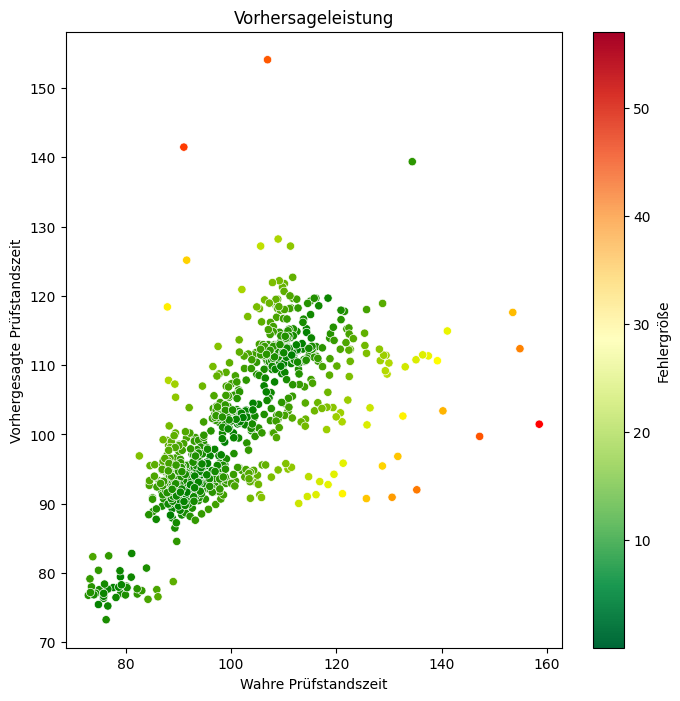

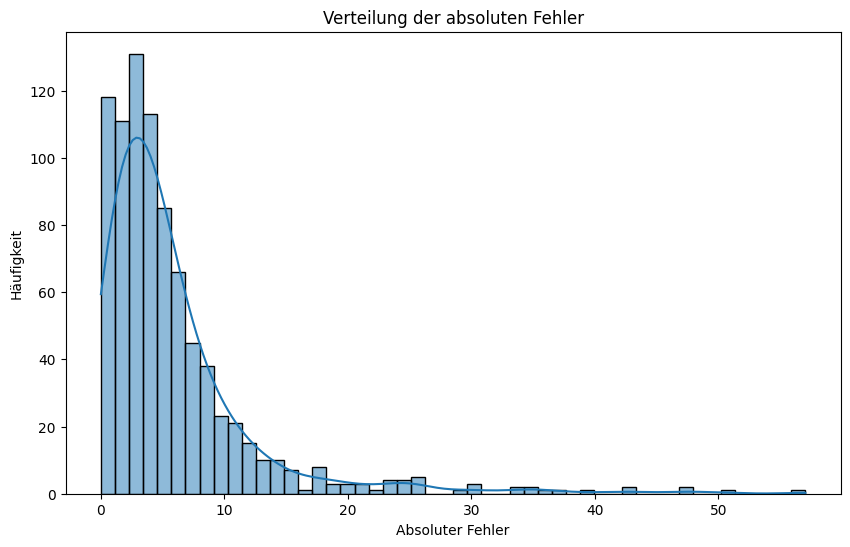

In [203]:
def predict():
    """
    Macht Vorhersagen auf den Testdaten und berechnet die Leistung des Modells.
    """

    # Vorhersagen auf Testdaten machen
    y_pred = model.predict(X_test)

    # Leistung des Modells bewerten
    mse = mean_squared_error(y_test, y_pred)
    abs_error = np.abs(y_test - y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {abs_error.mean()}")
    print(f"R^2: {r2}")

    # Scatterplot der wahren vs. vorhergesagten Werte
    fig, ax = plt.subplots(figsize=(8, 8))
    scatter = sns.scatterplot(
        x=y_test,
        y=y_pred,
        hue=np.abs(y_test - y_pred),
        palette=sns.color_palette("blend:green,yellow,red", as_cmap=True),
        ax=ax,
        legend=False,
    )
    ax.set_xlabel("Wahre Prüfstandszeit")
    ax.set_ylabel("Vorhergesagte Prüfstandszeit")
    ax.set_title("Vorhersageleistung")

    # Hinzufügen der Farbskala
    norm = plt.Normalize(np.abs(y_test - y_pred).min(), np.abs(y_test - y_pred).max())
    sm = plt.cm.ScalarMappable(cmap="RdYlGn_r", norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label="Fehlergröße")

    plt.show()

    # Verteilung der Fehler visualisieren
    plt.figure(figsize=(10, 6))
    sns.histplot(abs_error, kde=True, bins=50)
    plt.title("Verteilung der absoluten Fehler")
    plt.xlabel("Absoluter Fehler")
    plt.ylabel("Häufigkeit")
    plt.show()


predict()

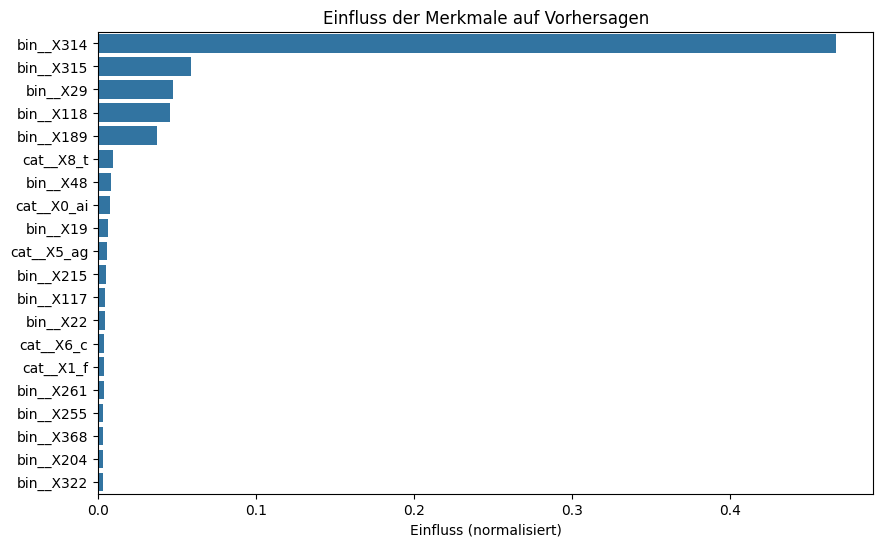

Preprocessing results in 561 features
Top 20 features: ['bin__X314' 'bin__X315' 'bin__X29' 'bin__X118' 'bin__X189' 'cat__X8_t'
 'bin__X48' 'cat__X0_ai' 'bin__X19' 'cat__X5_ag' 'bin__X215' 'bin__X117'
 'bin__X22' 'cat__X6_c' 'cat__X1_f' 'bin__X261' 'bin__X255' 'bin__X368'
 'bin__X204' 'bin__X322']


In [210]:
def feature_importance():
    """
    Visualisiert die wichtigsten Merkmale des trainierten Modells.
    """

    # Wichtigkeit der Merkmale abrufen
    importances = model.named_steps["regressor"].feature_importances_

    # Merkmale und ihre W
    feature_names = model.named_steps["preprocessor"].get_feature_names_out()

    # Wichtigkeit der Merkmale sortieren
    indices = np.argsort(importances)[::-1][:20]

    # Wichtigkeit der Merkmale visualisieren
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices], y=feature_names[indices])
    plt.title("Einfluss der Merkmale auf Vorhersagen")
    plt.xlabel("Einfluss (normalisiert)")
    plt.show()

    print(f"Preprocessing results in {len(feature_names)} features")
    print(f"Top 20 features: {feature_names[indices]}")

    return importances, feature_names


importances, feature_names = feature_importance()

Zusätzlich untersuchen wir nun mit Hilfe einer Korrelationsanalyse, wie bestimmte Features die Zielvariable beeinflussen.

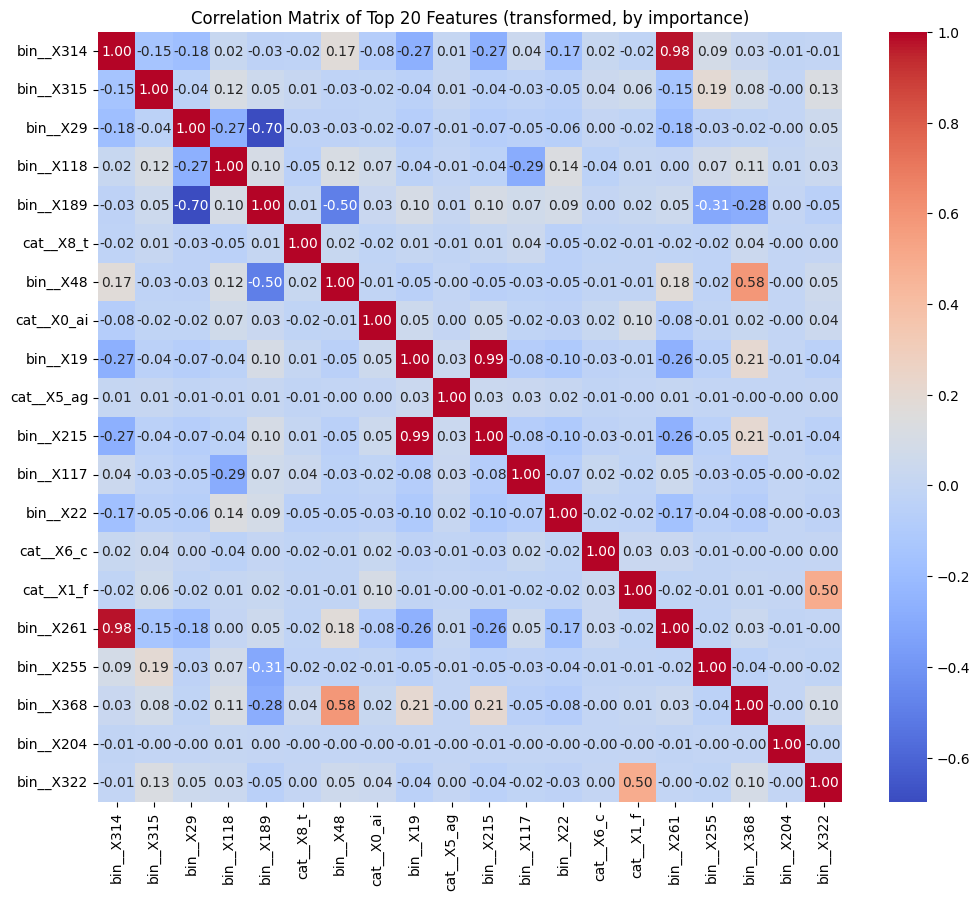

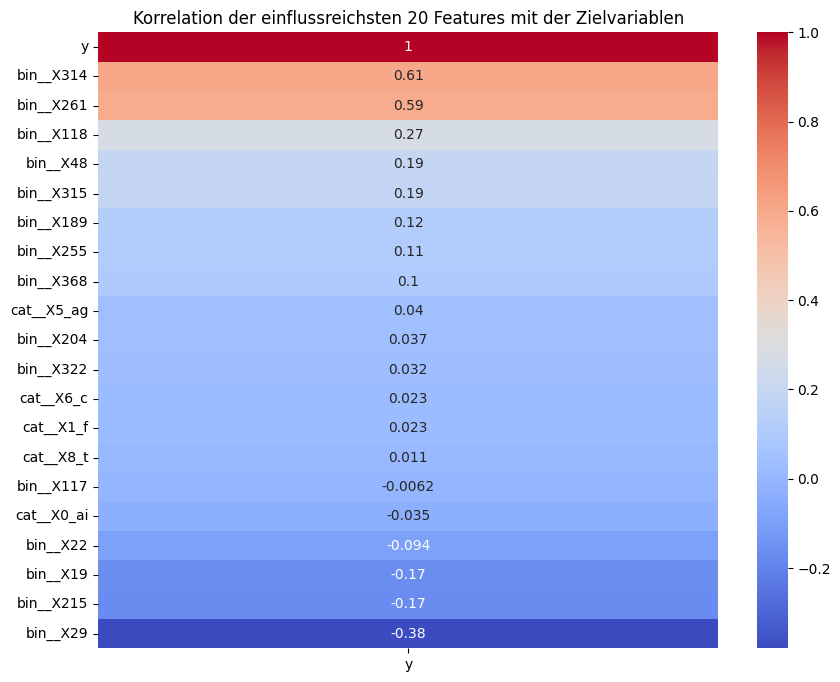

In [211]:
# Transformierten Datensatz mit allen Features als DataFrame anzeigen
X_transformed = pd.DataFrame(
    model.named_steps["preprocessor"].transform(X),
    columns=model.named_steps["preprocessor"].get_feature_names_out(),
)

# Rejoin the transformed data with the target variable and ID
df_transformed = pd.concat([X_transformed, y], axis=1)


# Reduce the number of featrues to the 20 most important ones
top_features = feature_names[np.argsort(importances)[::-1][:20]]

# Plot the top 20 features
plt.figure(figsize=(12, 10))
sns.heatmap(df_transformed[top_features].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Top 20 Features (transformed, by importance)")
plt.show()


# Visualize correlation between the top 20 features and the target variable
plt.figure(figsize=(10, 8))
sns.heatmap(
    df_transformed[top_features]
    .join(y)
    .corr()[["y"]]
    .sort_values("y", ascending=False),
    annot=True,
    cmap="coolwarm",
)
plt.title("Korrelation der einflussreichsten 20 Features mit der Zielvariablen")
plt.show()

Sensitivitätsanalyse für Feature: X1
Ursprünglicher Wert: v
Einzigartige Werte für das Feature: ['v' 't' 'w' 'b' 'r' 'l' 's' 'aa' 'c' 'a' 'e' 'h' 'z' 'j' 'o' 'u' 'p' 'n'
 'i' 'y' 'd' 'f' 'm' 'k' 'g' 'q' 'ab']


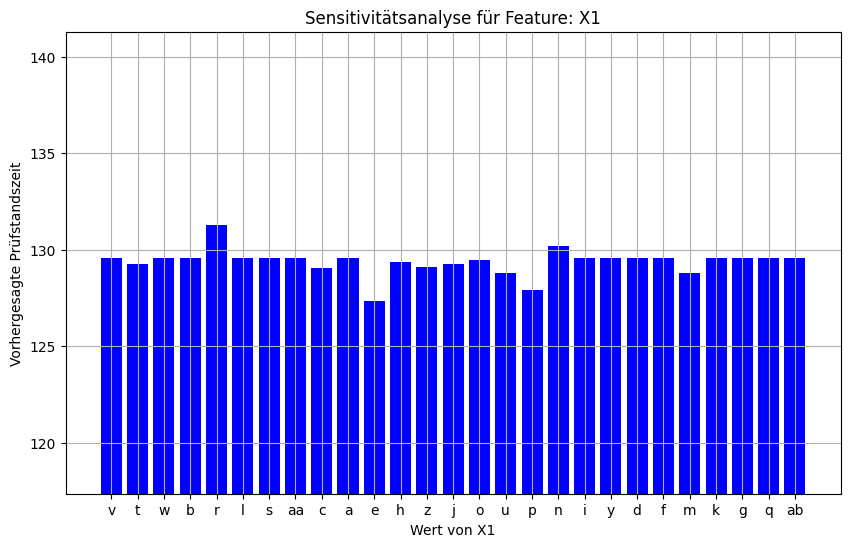

In [206]:
def categorical_sensitivity_analysis(model, X_train, feature_names, feature_index):
    """
    Führt eine Sensitivitätsanalyse für ein binäres oder kategorisches Feature durch.

    Parameters:
    - model: Das trainierte Modell.
    - X_train: Ein DataFrame mit den Trainingsdaten.
    - feature_names: Liste der Feature-Namen.
    - feature_index: Index des Features, das variiert werden soll.
    """

    # Das Feature auswählen, das analysiert werden soll
    original_value = X_train.iloc[0, feature_index]
    unique_values = X_train.iloc[:, feature_index].unique()

    print(f"Sensitivitätsanalyse für Feature: {feature_names[feature_index]}")
    print(f"Ursprünglicher Wert: {original_value}")
    print(f"Einzigartige Werte für das Feature: {unique_values}")

    predictions = []

    # Vorhersagen für die verschiedenen Werte des Features berechnen
    for val in unique_values:
        X_temp = X_train.iloc[0, :].copy()  # Kopie der Zeile erstellen
        X_temp.iloc[feature_index] = val  # Den Feature-Wert ändern
        X_temp = pd.DataFrame([X_temp])  # In DataFrame umwandeln
        prediction = model.predict(X_temp)[0]
        predictions.append((val, prediction))

        # Ergebnisse visualisieren
    values, preds = zip(*predictions)
    plt.figure(figsize=(10, 6))
    plt.bar(values, preds, color="blue")
    plt.title(f"Sensitivitätsanalyse für Feature: {feature_names[feature_index]}")
    plt.xlabel(f"Wert von {feature_names[feature_index]}")
    plt.ylabel("Vorhergesagte Prüfstandszeit")
    plt.ylim(min(preds) - 10, max(preds) + 10)  # Y-Achse anpassen
    plt.grid(True)
    plt.show()


# Beispielaufruf:
X = df.drop(columns=["y"])
all_features = X.columns

# Beispielsweise für das erste Feature (kategorisch oder binär):
for i in range(2, 3):
    categorical_sensitivity_analysis(model, X, all_features, feature_index=i)

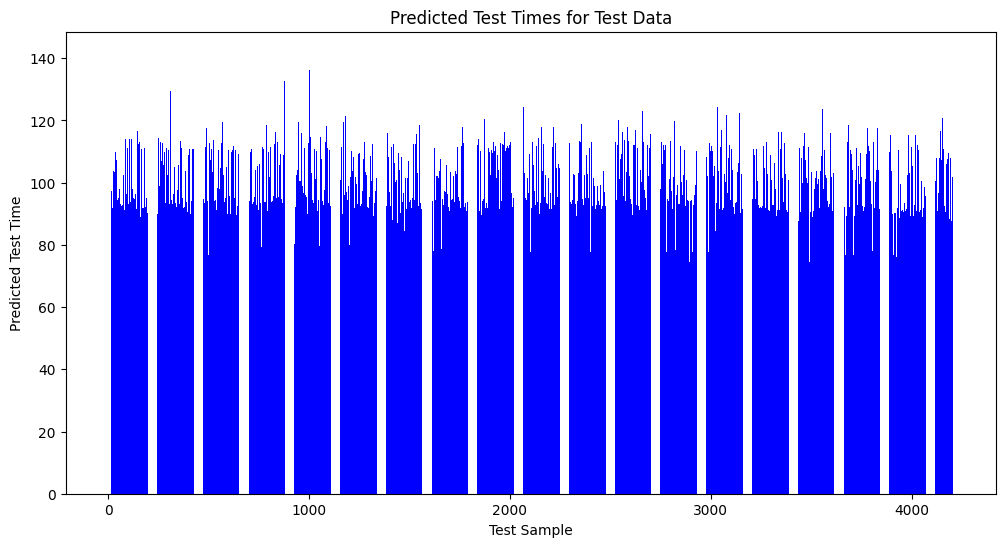

In [207]:
# Load the test data
test_data = pd.read_csv("data/test.csv")

# Make predictions on the test data
test_predictions = model.predict(test_data)

# Visualize the predictions in a bar plot (one bar for each test sample)
plt.figure(figsize=(12, 6))
plt.bar(range(len(test_predictions)), test_predictions, color="blue")
plt.xlabel("Test Sample")
plt.ylabel("Predicted Test Time")
plt.title("Predicted Test Times for Test Data")
plt.show()

## Takeaways for die Optimierung der Prüfstandzeiten

Ergebnisse:

- Die Fahrzeuge stehen im Schnitt 100.7 Einheiten auf dem Prüfstand. Die Verteilung der Prüfstandzeiten ist grob an einer Normalverteilung orientiert. (std = 12.7)
- Die Features X314 und X261 haben eine hohe Importance UND korrelieren mit der Zielvariable. D.h. Fahrzeuge mit dieser Ausstattung haben tendenziell eine längere Prüfstandzeit. Das sollte in der Prüfstandplanung berücksichtigt werden.

- Das Modell hat eine Abweichung von 5.83. Das bedeutet, dass die Prüfstandzeit eines Fahrzeugs mit einer Genauigkeit von 95% vorhergesagt werden kann.

- Es wäre sinnvoll die Prüfstandzeit eines eingehenden Fahrzeugs damit vorherzusagen. So könnte man damit folgendes optimieren:

    - Just-in-time-Produktion: Die Prüfstandzeiten könnten so geplant werden, dass die Fahrzeuge genau dann auf den Prüfstand kommen, wenn dieser frei ist. Das würde ungeplante Wartezeiten vermeiden.
    - Parellisierung von langen und kurzen Prüfstandzeiten: Fahrzeuge mit langer Prüfstandzeit könnten so geplant werden, dass sie parallel zu Fahrzeugen mit kurzer Prüfstandzeit auf den Prüfstand kommen. So könnte die Auslastung des Prüfstands optimiert werden.

Ausblick:

- Andere Modellarchitekturen wie neuronale Netze könnten ebenfalls getestet werden, um die Vorhersagegenauigkeit zu verbessern. Hier müsste jedoch darauf geachtet werden, dass die Interpretierbarkeit der Features nicht verloren und die Anzahl der Features nicht zu groß wird.
